# Evaluation of Phase 0

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
import math

import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from tsdr.testseries import sockshop

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import ruptures as rpt

In [2]:
from meltria import loader

metrics_files = !find /datasets/metrics-hg68n-errors/ -name "*.json" | grep -v network | grep '_0'
dataset, mappings = loader.load_dataset(metrics_files, exclude_middleware_metrics=False)
records = []
for (chaos_type, chaos_comp), sub_df in dataset.groupby(level=[0, 1]):
    for (metrics_file, grafana_dashboard_url), data_df in sub_df.groupby(level=[2, 3]):
        record = loader.DatasetRecord(chaos_type, chaos_comp, metrics_file, data_df)
        records.append(record)

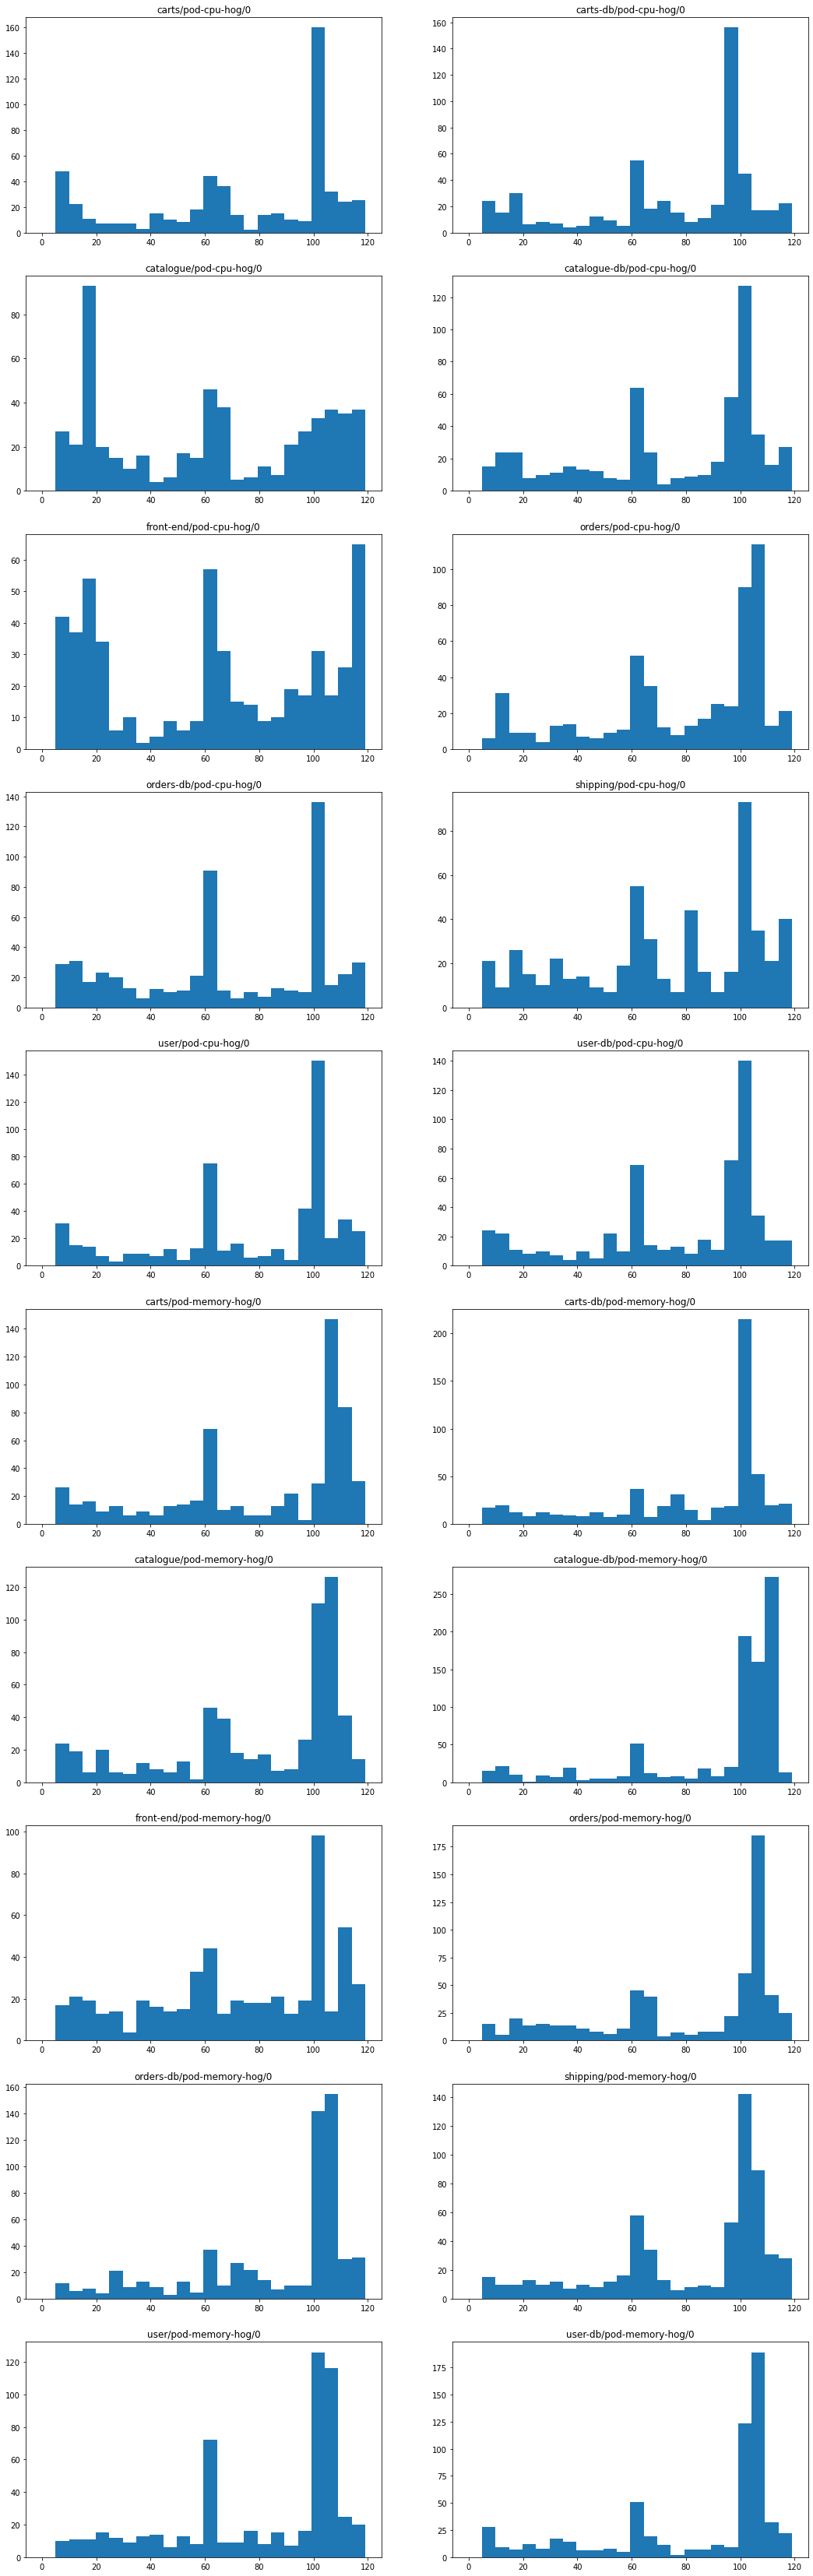

In [26]:
import warnings

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

fig, axs = plt.subplots(math.ceil(len(records)/2), ncols=2)
fig.set_size_inches(18, 3*len(records))
for record, ax in zip(records, axs.flatten()):
    df = record.data_df

    def detect_anomaly(x) -> int:
        if np.all(x == x[0]) or np.all(np.isnan(x)):
            return -1
        # detect change start time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            algo = rpt.Binseg(model='normal').fit(x)
        bkp = algo.predict(n_bkps=1)[0]
        return bkp
        # # detect anomality
        # ols = OLS(x, add_constant(np.arange(1, bkp+1))).fit()
        # std = ols.resid.std()
        # if std == 0:
        #     std = 1
        # resids = ols.resid / std

        # intersected_idxs: np.ndarray = np.where(np.diff(np.sign(resids)))[0] + 1
        # sections = np.split(resids, indices_or_sections=intersected_idxs)
        # rsses = np.array([np.sum(sec**2) for sec in sections])
        # max_rss_sec_idx: np.intp = np.argmax(rsses)
        # max_rss_start: int = 0 if max_rss_sec_idx == 0 else np.sum([sec.size for sec in sections[:max_rss_sec_idx]])
        max_rss: float = rsses[max_rss_sec_idx]
        # max_rss_sec: list[tuple[int, float]] = [(max_rss_start+i, v) for i, v in enumerate(sections[max_rss_sec_idx])]
        return max_rss

    bkps = np.apply_along_axis(detect_anomaly, 0, df.to_numpy())

    ax.set_title(record.chaos_case_full())
    ax.hist(bkps, range=(0, 119), bins=24)